#**PROJET MACHINE LEARNING SUR LA PREDICTION DES PRIX DE VOITURE HYUNDAI**

## **Nettoyage des donn√©es et ing√©nierie des caract√©ristiques**

     Price    Levy Manufacturer    Model  Prod. year   Category  \
0  13328.0  1399.0        LEXUS   RX 450      2010.0       Jeep   
1  16621.0  1018.0    CHEVROLET  Equinox      2011.0       Jeep   
2   8467.0     0.0        HONDA      FIT      2006.0  Hatchback   
3   3607.0   862.0         FORD   Escape      2011.0       Jeep   
4  11726.0   446.0        HONDA      FIT      2014.0  Hatchback   

  Leather interior Fuel type Engine volume   Mileage  Cylinders Gear box type  \
0              Yes    Hybrid           3.5  186005.0        6.0     Automatic   
1               No    Petrol             3  192000.0        6.0     Tiptronic   
2               No    Petrol           1.3  200000.0        4.0      Variator   
3              Yes    Hybrid           2.5  168966.0        4.0     Automatic   
4              Yes    Petrol           1.3   91901.0        4.0     Automatic   

  Drive wheels   Doors             Wheel   Color  Airbags  
0          4x4  04-May        Left wheel  Silver  

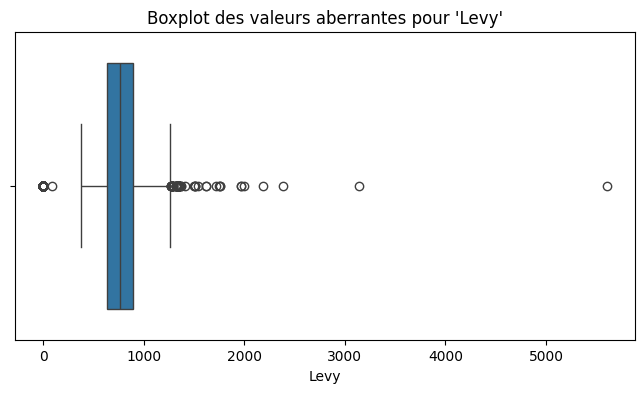

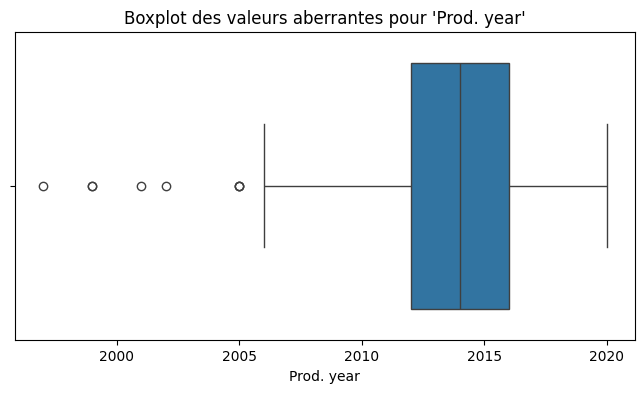

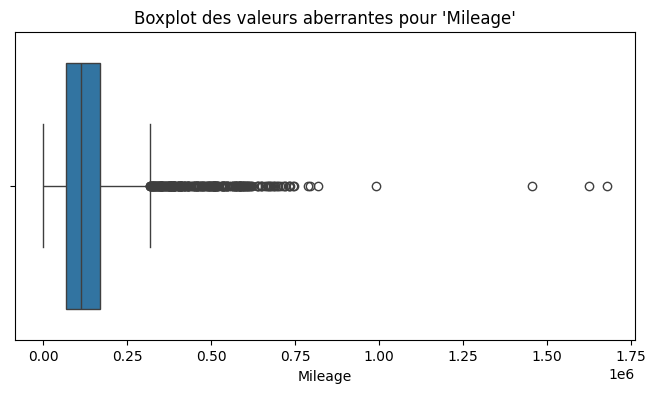

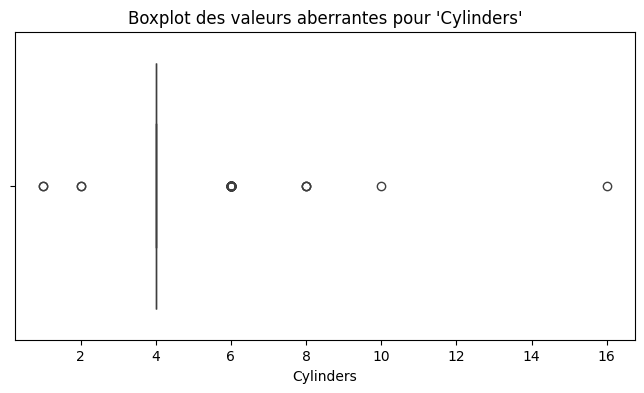

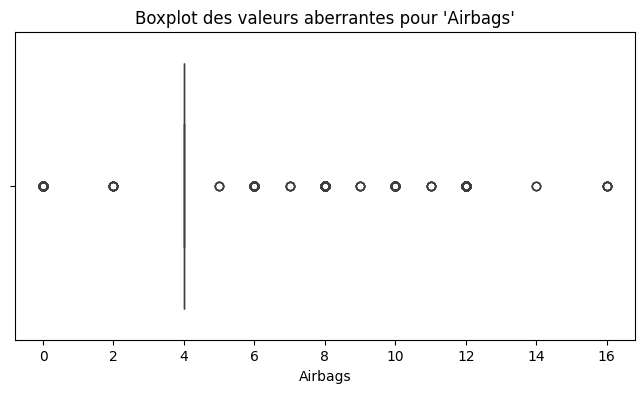

üöó Top 100 des valeurs les plus √©lev√©es de 'Mileage' :
10644    1678000.0
14134    1624000.0
16733    1456394.0
1170      990000.0
7763      820000.0
           ...    
14583     509460.0
14697     509454.0
4130      509454.0
12100     509362.0
6278      505900.0
Name: Mileage, Length: 100, dtype: float64
üöó Top 10 des valeurs les plus √©lev√©es de 'Mileage' :
0    587027.0
1    587027.0
2    586667.0
3    586436.0
4    585977.0
5    583499.0
6    582376.0
7    581040.0
8    577053.0
9    576605.0
Name: Mileage, dtype: float64
colonne consid√©r√© en obj Manufacturer
colonne consid√©r√© en obj Model
colonne consid√©r√© en obj Category
colonne consid√©r√© en obj Leather interior
colonne consid√©r√© en obj Fuel type
colonne consid√©r√© en obj Engine volume
colonne consid√©r√© en obj Gear box type
colonne consid√©r√© en obj Drive wheels
colonne consid√©r√© en obj Doors
colonne consid√©r√© en obj Wheel
colonne consid√©r√© en obj Color
Aper√ßu des donn√©es nettoy√©es pour les v√©hicule

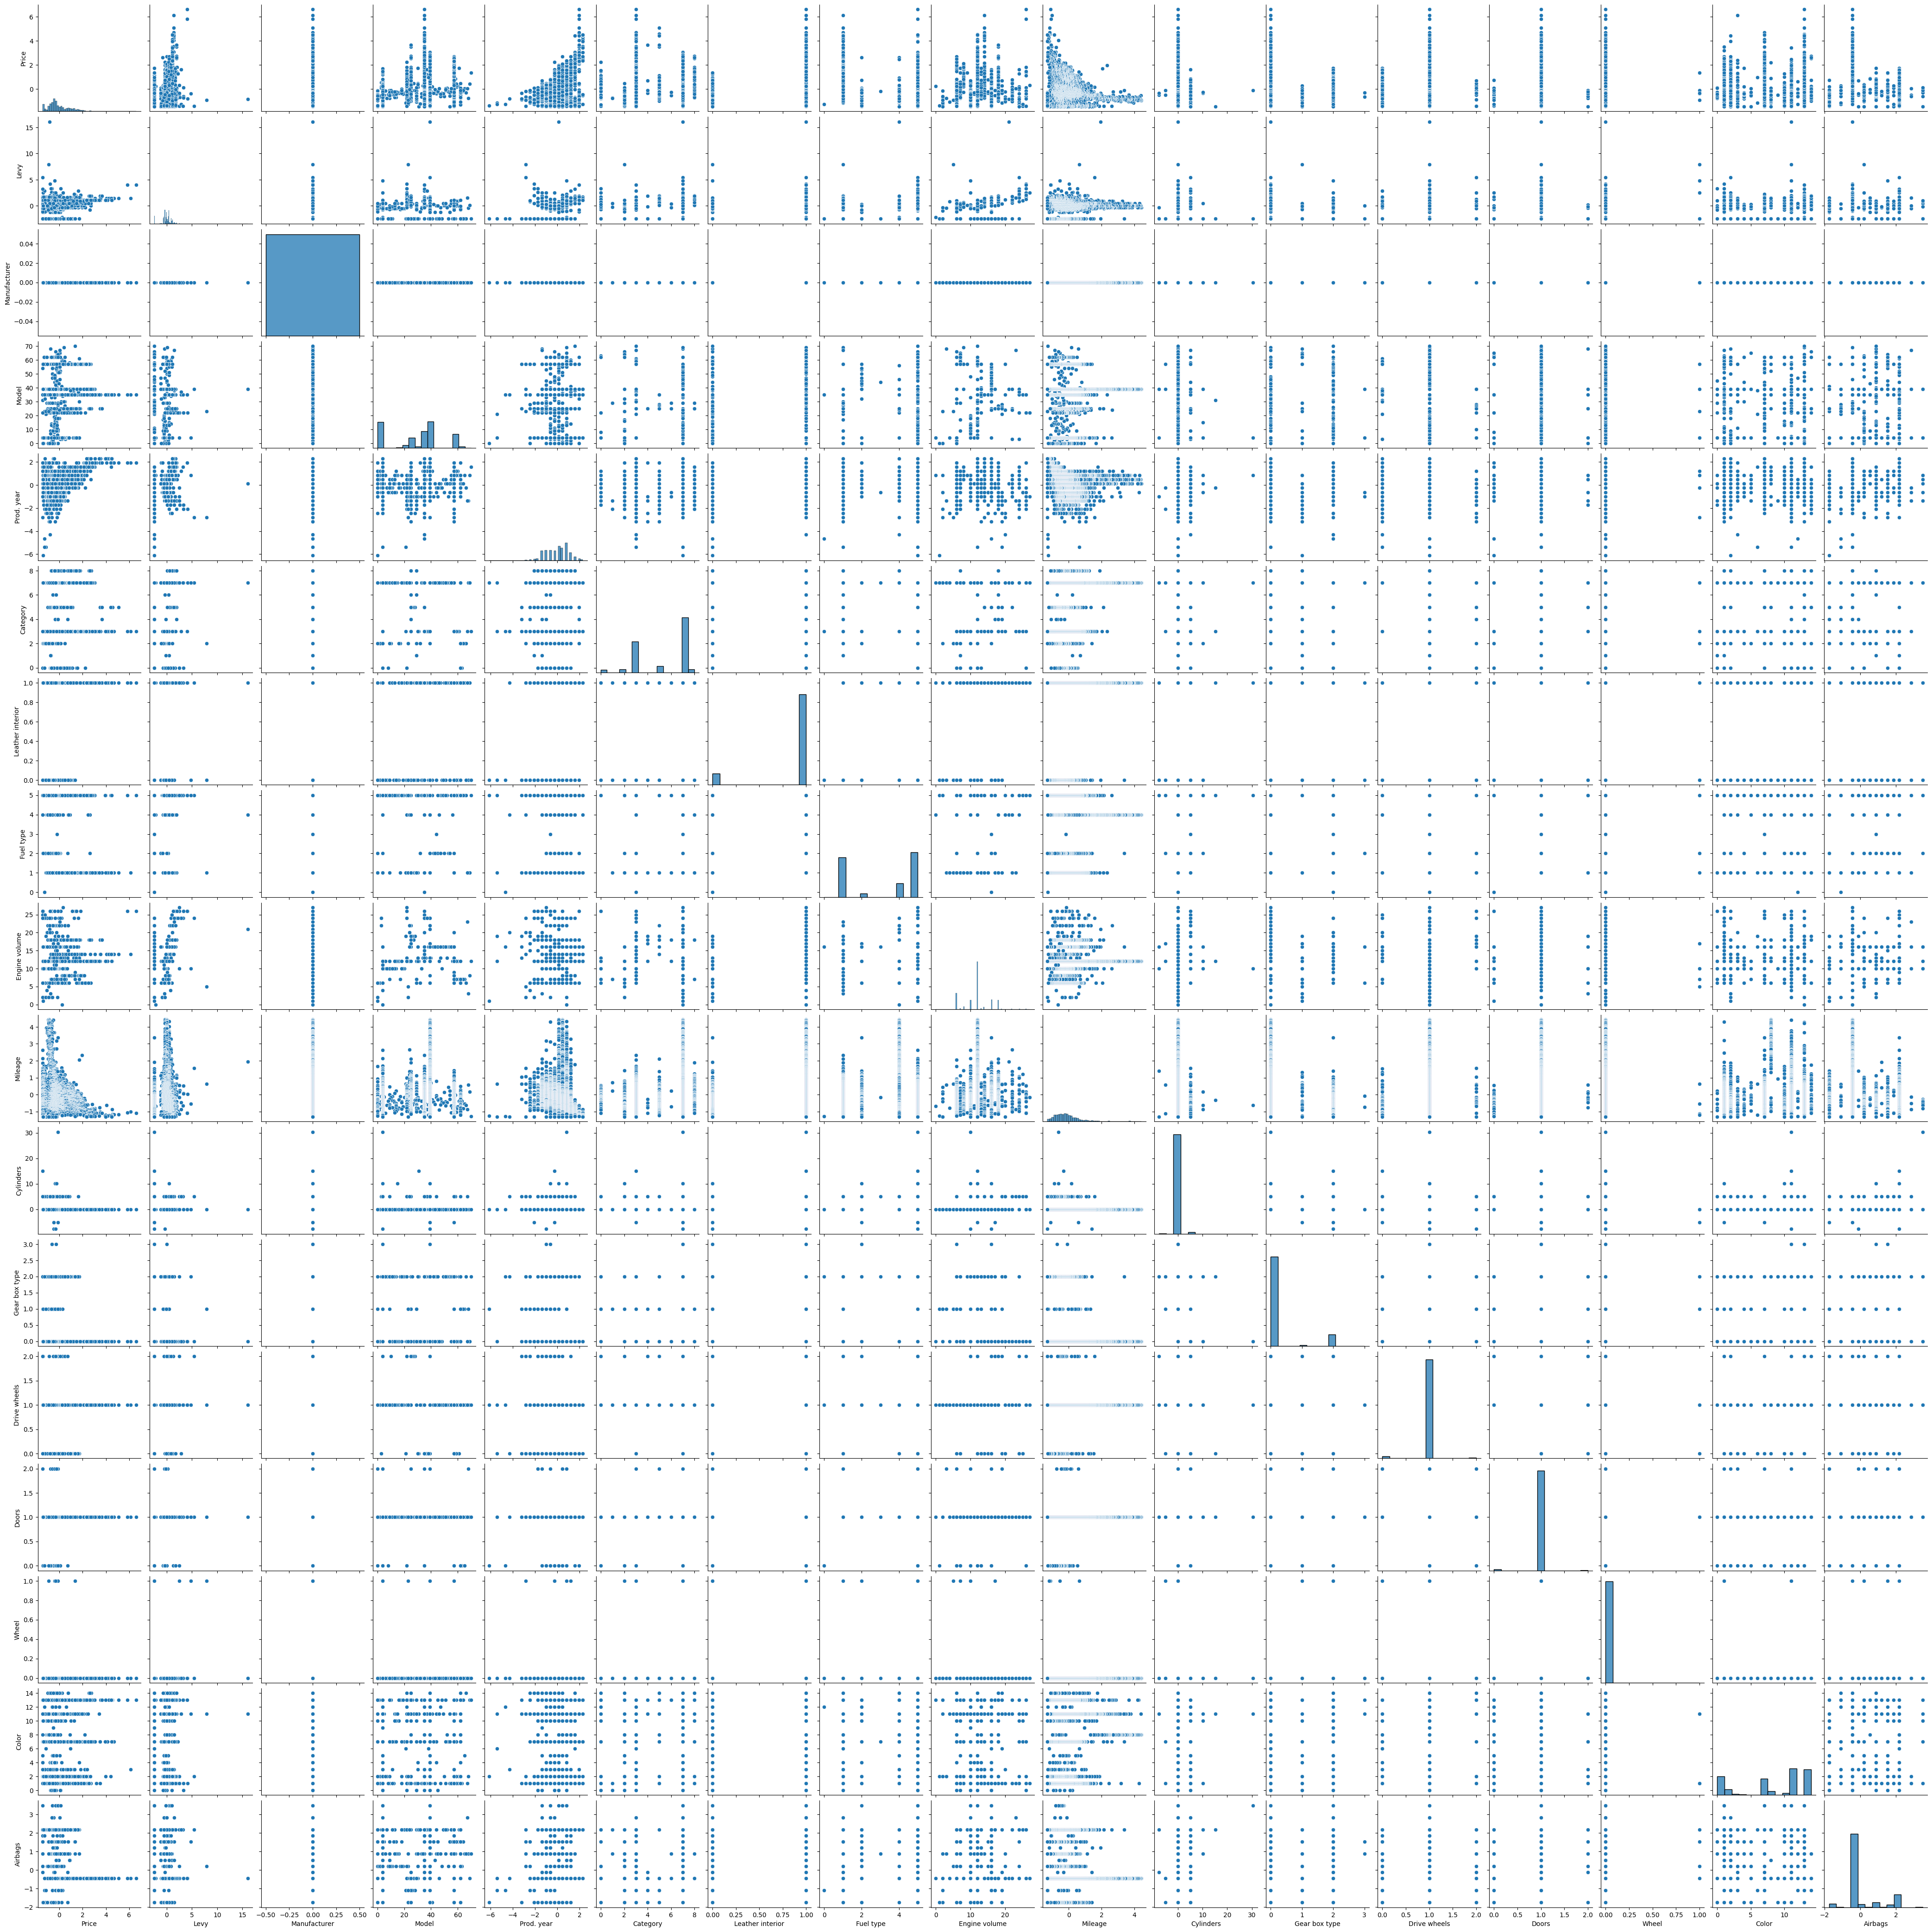

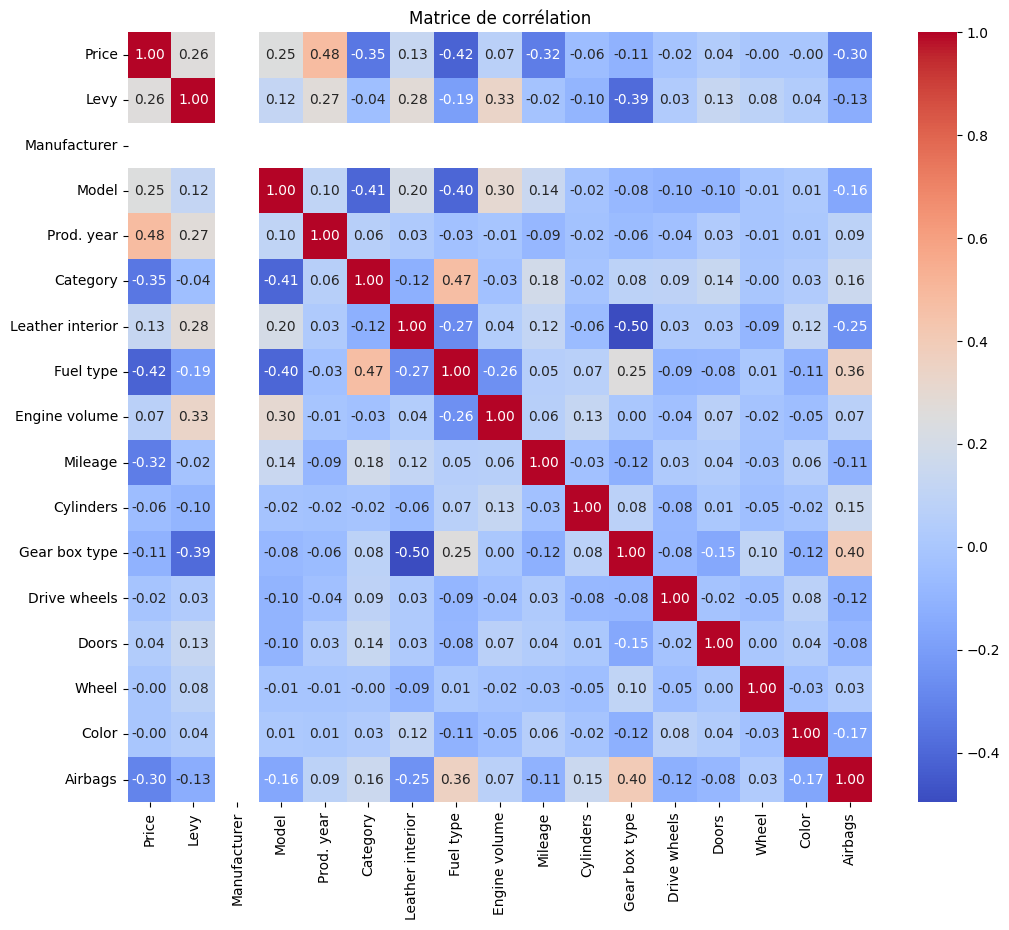

üîç Colonnes avec une faible corr√©lation avec 'Price':
['Color', 'Wheel', 'Drive wheels', 'Doors', 'Cylinders', 'Engine volume']
      Price      Levy  Model  Prod. year  Category  Leather interior  \
0 -0.925115 -0.355838     39    0.107295         7                 1   
1 -0.920154 -0.355838     39    0.107295         7                 1   
2 -0.872071  0.061514     39    0.473491         7                 1   
3 -0.516745  0.061514     39    0.473491         7                 1   
4 -0.939326  0.061514     39    0.473491         7                 1   

   Fuel type   Mileage  Gear box type   Airbags  
0          4  4.425752              0 -0.443566  
1          4  4.425752              0 -0.443566  
2          4  4.422236              0 -0.443566  
3          4  4.419980              0 -0.443566  
4          4  4.415496              0 -0.443566  


In [ ]:
# Import des librairies fondamentales pour l'analyse de donn√©es et le machine learning
import pandas as pd
import seaborn as sns
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,make_scorer
from sklearn.model_selection import KFold

# Chargement du dataset depuis le fichier CSV
file_path = 'car_price_prediction.csv'
df = pd.read_csv(file_path)

# Nettoyage des identifiants superflus du dataset
if 'ID' in df.columns:
    df = df.drop('ID', axis=1)
else:
    print("‚ö†Ô∏è La colonne 'id' n'existe pas dans le dataset. Veuillez v√©rifier.")

# Pr√©traitement des colonnes num√©riques :
# - Conversion des tirets en z√©ros pour la colonne Levy
# - Nettoyage de la colonne Mileage (suppression 'km' et virgules)
df["Levy"] = df["Levy"].str.replace('-', "0").astype(float)
df['Mileage'] = df['Mileage'].str.replace('km', '', regex=True).str.replace(',', '').astype(float)

# Affichage des premi√®res lignes
print(df.head())

# Supprimer les doublons
df.drop_duplicates(inplace=True)

# Supprimer les colonnes avec plus de 50% de valeurs manquantes
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

# Remplir les valeurs manquantes restantes avec la m√©diane (pour les valeurs num√©riques)
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# V√©rification des types de donn√©es
print(df.dtypes)

# Filtrage sp√©cifique aux v√©hicules Hyundai :
# - S√©lection uniquement des v√©hicules de la marque
# - Validation des prix (doivent √™tre positifs)
# - V√©rification de la coh√©rence temporelle des ann√©es
if 'Manufacturer' in df.columns:
    df = df[df['Manufacturer'].str.contains('HYUNDAI', case=False, na=False)]
else:
    print("‚ö†Ô∏è La colonne Manufacturer n'existe pas dans le dataset. Veuillez v√©rifier.")
if 'price' in df.columns:
    df = df[df['price'] > 0]
# Exemple : ann√©e de fabrication valide entre 1980 et 2024
if 'year' in df.columns:
    df = df[(df['year'] >= 1980) & (df['year'] <= 2024)]

# D√©tection des valeurs aberrantes par m√©thode des quartiles :
# 1. Calcul de l'√©cart interquartile (IQR)
# 2. D√©finition des seuils (Q1 - 1.5*IQR et Q3 + 1.5*IQR)
# 3. Identification des outliers pour chaque variable num√©rique

# 1.
Q1 = df[numeric_cols].quantile(0.25)  # Premier quartile (25%)
Q3 = df[numeric_cols].quantile(0.75)  # Troisi√®me quartile (75%)
IQR = Q3 - Q1  # Intervalle interquartile

# 2. D√©finir les bornes inf√©rieure et sup√©rieure pour les valeurs aberrantes
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. Cr√©er un dictionnaire pour stocker les valeurs aberrantes par colonne
outliers = {}
for col in numeric_cols:
    outliers[col] = df[(df[col] < lower_bound[col]) | (df[col] > upper_bound[col])]

# Visualisation des distributions et des valeurs aberrantes :
# - Cr√©ation de boxplots pour chaque variable num√©rique
# - Identification visuelle des points extr√™mes
for col, data in outliers.items():
    print(f"üìä Colonne '{col}': {len(data)} valeurs aberrantes d√©tect√©es.")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot des valeurs aberrantes pour '{col}'")
    plt.show()


# Traitement sp√©cifique du kilom√©trage :
# 1. Identification des 100 v√©hicules les plus kilom√©tr√©s
# 2. Suppression des 50 cas les plus extr√™mes
# 3. V√©rification post-traitement avec top 10

# 1.
top_100_mileage = df['Mileage'].sort_values(ascending=False).head(100)
print("üöó Top 100 des valeurs les plus √©lev√©es de 'Mileage' :")
print(top_100_mileage)
df = df.sort_values(by='Mileage', ascending=False)

# 2.
df = df.iloc[50:].reset_index(drop=True)

# 3.
top_10_mileage = df['Mileage'].sort_values(ascending=False).head(10)
print("üöó Top 10 des valeurs les plus √©lev√©es de 'Mileage' :")
print(top_10_mileage)

# Encodage des variables :
# 1. Standardisation des variables num√©riques (moyenne=0, √©cart-type=1)
# 2. Encodage des variables cat√©gorielles via LabelEncoder
# 3. Tentative de conversion num√©rique pour les colonnes restantes

# 1.
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# 2.
label_encoder = LabelEncoder()

for col in df.select_dtypes(include=['object']).columns:
    print("colonne consid√©r√© en obj",col)

    if df[col].dtype == 'object':
        df[col] = label_encoder.fit_transform(df[col])
    try:
# 3.
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass

# Visualisation des donn√©es post-traitement :
# 1. Cr√©ation d'un pairplot pour observer les relations bivari√©es
# 2. G√©n√©ration d'une matrice de corr√©lation avec heatmap
# 3. Identification des variables peu corr√©l√©es avec le prix

# 1.
print("Aper√ßu des donn√©es nettoy√©es pour les v√©hicules Hyundai :")
print(df.head())
sns.pairplot(df)
plt.show()

# 2. G√©n√©rer la matrice de corr√©lation
correlation_matrix = df.corr(numeric_only=True)  # Calculer la matrice de corr√©lation
plt.figure(figsize=(12, 10))  # Ajuster la taille de la figure si n√©cessaire
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f") # Cr√©er le heatmap
plt.title("Matrice de corr√©lation") # Ajouter un titre
plt.show() # Afficher le heatmap

# 3. Identifier les colonnes avec une faible corr√©lation avec 'Price'
low_correlation = correlation_matrix['Price'].abs().sort_values()
low_corr_columns = low_correlation[low_correlation < 0.1].index.tolist()

print("üîç Colonnes avec une faible corr√©lation avec 'Price':")
print(low_corr_columns)

# Nettoyage final :
# - Suppression des variables faiblement corr√©l√©es avec le prix
# - Retrait de la variable Manufacturer devenue redondante
df.drop(columns=low_corr_columns, inplace=True)
df.drop(columns="Manufacturer", inplace=True)
print(df.head())



## **S√©lection des mod√®les et verification**

In [ ]:
# Pr√©paration des donn√©es pour l'entra√Ænement des mod√®les :
# - X : ensemble des variables explicatives (features)
# - y : variable cible (Price)

X = df.drop('Price', axis=1)
y = df['Price']

# S√©paration des donn√©es en sets d'entra√Ænement (80%) et de test (20%)
# random_state fix√© pour assurer la reproductibilit√© des r√©sultats
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mod√®le 1 : R√©gression Lin√©aire
# Entra√Ænement d'un mod√®le de r√©gression lin√©aire simple
# Utile comme baseline pour comparer avec des mod√®les plus complexes
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# √âvaluation du mod√®le lin√©aire avec plusieurs m√©triques :
# - MSE : erreur quadratique moyenne
# - RMSE : racine de l'erreur quadratique moyenne
# - MAE : erreur absolue moyenne
# - R¬≤ : coefficient de d√©termination
mse_lin = mean_squared_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)
mae_lin = mean_absolute_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print(f"üìä R√©gression Lin√©aire - MSE: {mse_lin:.2f}, RMSE: {rmse_lin:.2f}, MAE: {mae_lin:.2f}, R¬≤: {r2_lin:.2f}")


# Mod√®le 2 : Random Forest
# Mod√®le plus complexe bas√© sur 200 arbres de d√©cision
# Capable de capturer des relations non-lin√©aires
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# √âvaluer le mod√®le Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"üå≥ Random Forest - MSE: {mse_rf:.2f}, RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}, R¬≤: {r2_rf:.2f}")


# Mod√®le 3 : Support Vector Regression (SVR)
# Pr√©paration sp√©cifique : standardisation des donn√©es n√©cessaire pour SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Configuration et entra√Ænement du SVR :
# - kernel='rbf' : noyau gaussien pour capturer les non-lin√©arit√©s
# - C=1.0 : param√®tre de r√©gularisation
# - epsilon=0.1 : marge de tol√©rance
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)

# √âvaluer le mod√®le SVR
mse_svr = mean_squared_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)
print(f"ü§ñ SVR - MSE: {mse_svr:.2f}, RMSE: {rmse_svr:.2f}, MAE: {mae_svr:.2f}, R¬≤: {r2_svr:.2f}")

# Comparaison des mod√®les
models_scores = {
    "R√©gression Lin√©aire": r2_lin,
    "Random Forest": r2_rf,
    "SVR": r2_svr
}

best_model = max(models_scores, key=models_scores.get)
print(f"üèÜ Le meilleur mod√®le est : {best_model} avec un score R¬≤ de {models_scores[best_model]:.2f}")



üìä R√©gression Lin√©aire - MSE: 0.45, RMSE: 0.67, MAE: 0.49, R¬≤: 0.53
üå≥ Random Forest - MSE: 0.14, RMSE: 0.37, MAE: 0.25, R¬≤: 0.86
ü§ñ SVR - MSE: 0.17, RMSE: 0.42, MAE: 0.26, R¬≤: 0.82
üèÜ Le meilleur mod√®le est : Random Forest avec un score R¬≤ de 0.86


## **Etude d'ablation**

In [ ]:
# Fonction d'√©tude d'ablation pour √©valuer l'importance de chaque feature
# Analyse l'impact de la suppression de chaque variable sur les performances du mod√®le
def ablation_study(model, X_train, X_test, y_train, y_test, baseline_score):
    # Dictionnaire pour stocker les r√©sultats de l'ablation pour chaque featur
    results = {}

    # Test it√©ratif de l'impact de la suppression de chaque feature
    for col in X_train.columns:
        # Cr√©er une copie des donn√©es sans la colonne courante
        X_train_ablation = X_train.drop(columns=[col])
        X_test_ablation = X_test.drop(columns=[col])

       # Cr√©ation de nouveaux jeux de donn√©es sans la feature test√©e
        model.fit(X_train_ablation, y_train)
        y_pred = model.predict(X_test_ablation)

        # Calcul des m√©triques de performance
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)

        # Stockage des r√©sultats et calcul de l'impact
        # Impact_R¬≤ : diff√©rence entre le score de base et le score sans la feature
        results[col] = {
            "R¬≤": r2,
            "RMSE": rmse,
            "MAE": mae,
            "Impact_R¬≤": baseline_score - r2
        }

    # Trier les r√©sultats par l'impact sur le R¬≤
    results = dict(sorted(results.items(), key=lambda x: x[1]['Impact_R¬≤'], reverse=True))

    # Afficher les r√©sultats
    for col, metrics in results.items():
        print(f"üîç **Caract√©ristique retir√©e : {col}**")
        print(f"   - R¬≤ : {metrics['R¬≤']:.2f}")
        print(f"   - RMSE : {metrics['RMSE']:.2f}")
        print(f"   - MAE : {metrics['MAE']:.2f}")
        print(f"   - Impact sur R¬≤ : {metrics['Impact_R¬≤']:.4f}\n")

    return results

# √âtablissement de la baseline de performance
# Entra√Ænement du mod√®le avec toutes les features pour r√©f√©rence
baseline_model = RandomForestRegressor(n_estimators=200, random_state=42)
baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)
baseline_r2 = r2_score(y_test, baseline_pred)

print(f"üèÅ Score de base (R¬≤) : {baseline_r2:.2f}")

# Lancement de l'√©tude d'ablation compl√®te
# Analyse de l'importance relative de chaque feature
ablation_results = ablation_study(baseline_model, X_train, X_test, y_train, y_test, baseline_r2)

üèÅ Score de base (R¬≤) : 0.86
üîç **Caract√©ristique retir√©e : Airbags**
   - R¬≤ : 0.77
   - RMSE : 0.47
   - MAE : 0.29
   - Impact sur R¬≤ : 0.0856

üîç **Caract√©ristique retir√©e : Prod. year**
   - R¬≤ : 0.80
   - RMSE : 0.44
   - MAE : 0.28
   - Impact sur R¬≤ : 0.0566

üîç **Caract√©ristique retir√©e : Fuel type**
   - R¬≤ : 0.82
   - RMSE : 0.42
   - MAE : 0.27
   - Impact sur R¬≤ : 0.0381

üîç **Caract√©ristique retir√©e : Model**
   - R¬≤ : 0.83
   - RMSE : 0.40
   - MAE : 0.26
   - Impact sur R¬≤ : 0.0211

üîç **Caract√©ristique retir√©e : Gear box type**
   - R¬≤ : 0.83
   - RMSE : 0.40
   - MAE : 0.26
   - Impact sur R¬≤ : 0.0208

üîç **Caract√©ristique retir√©e : Levy**
   - R¬≤ : 0.84
   - RMSE : 0.39
   - MAE : 0.26
   - Impact sur R¬≤ : 0.0145

üîç **Caract√©ristique retir√©e : Leather interior**
   - R¬≤ : 0.85
   - RMSE : 0.38
   - MAE : 0.25
   - Impact sur R¬≤ : 0.0072

üîç **Caract√©ristique retir√©e : Category**
   - R¬≤ : 0.86
   - RMSE : 0.37
   - M

## **Mesure d'analyse, r√©siduelle, courbe entre r√©elle et pr√©dite**

üìä MAE : 0.25
üìä RMSE : 0.37
üìä R¬≤ : 0.86


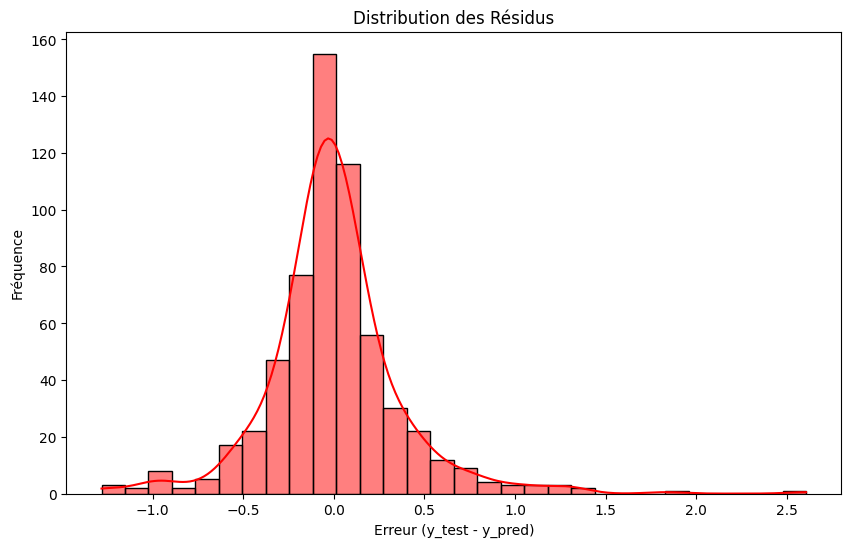

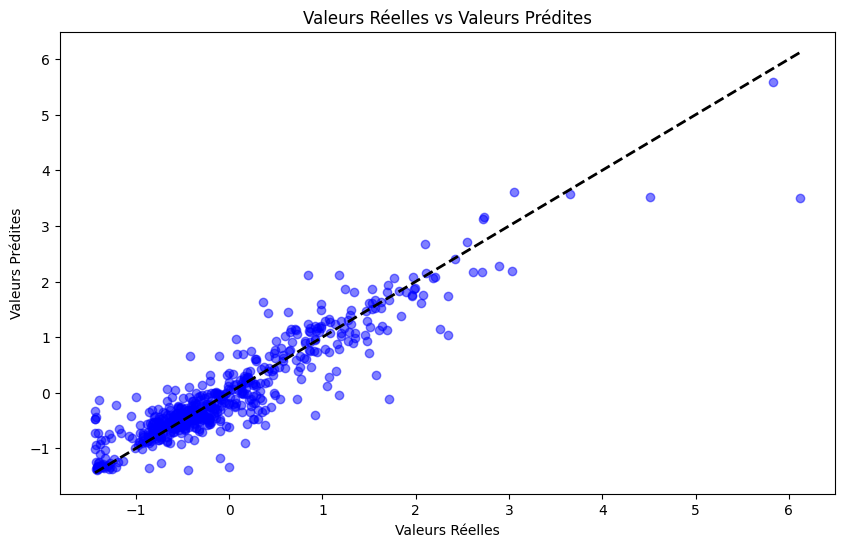

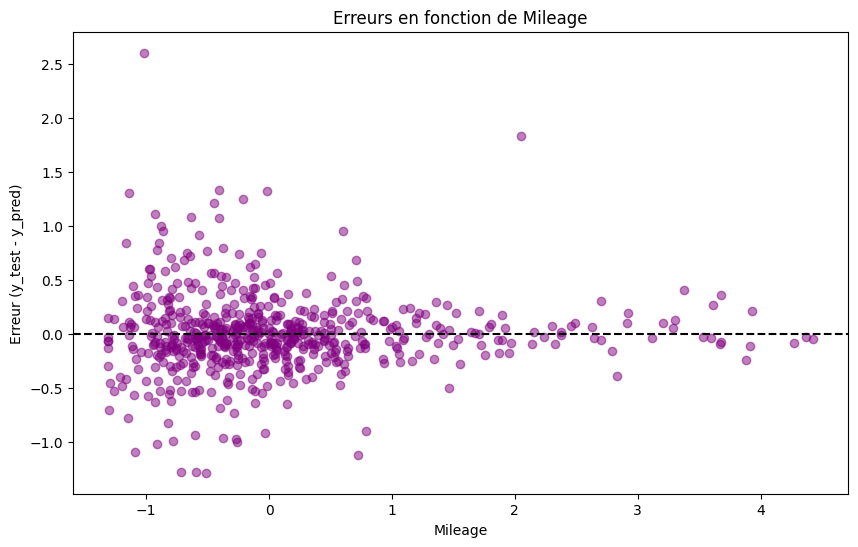

üîç Top 10 des plus grandes erreurs :
        Actual  Predicted     Error
2811  6.115480   3.509748  2.605732
162   1.716762  -0.116981  1.833743
1840  0.001940  -1.331196  1.333136
1151  0.923972  -0.404574  1.328546
2890  2.347600   1.037826  1.309774
1502  1.571349   0.323290  1.248059
1921  1.173698  -0.043397  1.217095
2706  2.257498   1.139982  1.117516
2236 -0.094104  -1.182207  1.088103
1842  0.174794  -0.899556  1.074350


In [ ]:
# Pr√©dictions avec le meilleur mod√®le
best_model = RandomForestRegressor(n_estimators=200, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Calcul des diff√©rentes m√©triques d'erreur
errors = y_test - y_pred  # Calcul des r√©sidus (diff√©rence entre valeurs r√©elles et pr√©dites)
mae = mean_absolute_error(y_test, y_pred) # Erreur absolue moyenne
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Racine carr√©e de l'erreur quadratique moyenne
r2 = r2_score(y_test, y_pred) # Coefficient de d√©termination R¬≤

# Affichage des m√©triques de performance avec formatage √† 2 d√©cimales
print(f"üìä MAE : {mae:.2f}") # Moyenne des valeurs absolues des erreurs
print(f"üìä RMSE : {rmse:.2f}") # Racine carr√©e de la moyenne des erreurs au carr√©
print(f"üìä R¬≤ : {r2:.2f}") # Pourcentage de variance expliqu√©e par le mod√®le

# Visualisation 1 : Distribution des r√©sidus
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color='red', bins=30)
plt.title("Distribution des R√©sidus")
plt.xlabel("Erreur (y_test - y_pred)")
plt.ylabel("Fr√©quence")
plt.show()

# Visualisation 2 : Comparaison valeurs r√©elles vs pr√©dites
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Valeurs R√©elles vs Valeurs Pr√©dites")
plt.xlabel("Valeurs R√©elles")
plt.ylabel("Valeurs Pr√©dites")
plt.show()

# Visualisation 3 : Analyse des r√©sidus en fonction d'une variable explicative
feature = 'Mileage'  # Exemple de variable importante
plt.figure(figsize=(10, 6))
plt.scatter(X_test[feature], errors, alpha=0.5, color='purple')
plt.title(f"Erreurs en fonction de {feature}")
plt.xlabel(feature)
plt.ylabel("Erreur (y_test - y_pred)")
plt.axhline(y=0, color='k', linestyle='--')
plt.show()

# Afficher les 10 plus grandes erreurs
error_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred, "Error": errors})
top_errors = error_df.sort_values(by="Error", ascending=False).head(10)
print("üîç Top 10 des plus grandes erreurs :")
print(top_errors)

## **cross validation : m√©thode K-Fold Cross-Validation**

In [ ]:
model = RandomForestRegressor(n_estimators=200, random_state=42)

# D√©finir le validateur K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# D√©finir une m√©trique personnalis√©e (RMSE)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Ex√©cuter la validation crois√©e
cv_scores = cross_val_score(model, X, y, cv=kf, scoring=scorer)

# Afficher les r√©sultats
print("üìä Scores RMSE pour chaque fold:", np.sqrt(-cv_scores))
print(f"üìä RMSE moyen : {np.sqrt(-cv_scores).mean():.2f}")

üìä Scores RMSE pour chaque fold: [0.36942697 0.37814088 0.35231474 0.30075175 0.37614667]
üìä RMSE moyen : 0.36


## **mod√®le de base : baseline al√©atoire**

In [23]:
# Pr√©diction baseline sur la moyenne du prix
y_pred_baseline = np.full_like(y_test, y_train.mean(), dtype=np.float64)

# √âvaluation du mod√®le baseline
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print(f"üõ†Ô∏è Mod√®le Baseline random - MSE: {mse_baseline:.2f}, R¬≤: {r2_baseline:.2f}")

üõ†Ô∏è Mod√®le Baseline random - MSE: 0.95, R¬≤: -0.00
